In [39]:
from ultralytics import YOLO
import numpy as np
from PIL import Image
import cv2
import colorsys
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
from fil_finder import FilFinder2D
import astropy.units as u

In [40]:
model = YOLO("best.pt") 

# Define the path to the input image
original_img = "131.jpg"

# Extract the base name of the input image file without the extension
image_base_name = os.path.splitext(os.path.basename(original_img))[0]

# Read the input image using OpenCV
original_img = cv2.imread(original_img)

# Get the height, width, and number of color channels of the input image
height, width, channels = original_img.shape

# Initialize a variable to store the desired image size (imgsz)
imgsz = None

# Determine the desired image size based on the width of the input image
if 500 < width < 2500:
    imgsz = 1024
elif 2500 < width < 5000:
    imgsz = 3000
elif 5000 < width < 9000:
    imgsz = 6000
elif width > 9000:
    imgsz = int(width * 0.75)
    
# If the image size could not be determined within the specified ranges, set it to 2048
if imgsz is None:
    imgsz = 512 
#print("imgsz:", imgsz)

In [41]:
# Use the YOLO model to detect objects in the input image
def detect(model, img):
    # Perform instance segmentation and store the results in the "results" variable
    results = model.predict(source=img.copy(), project="Result", name="pred", overlap_mask=False, imgsz=imgsz, save=True, iou=0.8, conf=0.6, save_txt=False)
    result = results[0]
        
    # Extract Masks, bounding boxes, class IDs, and scores from the result
    segment = result.masks.cpu().data.numpy()
    bboxes = np.array(result.boxes.xyxy.cpu(), dtype="int")
    class_ids = np.array(result.boxes.cls.cpu(), dtype="int")
    scores = np.array(result.boxes.conf.cpu(), dtype="float").round(2)
    points = result.masks.xy
    
    # Return the detected bounding boxes, class IDs, segments, and scores
    return bboxes, points, class_ids, segment, scores

In [42]:
   """
    Draw a mask on an image using specified points and color with optional transparency.

    Parameters:
    - img: The input image on which the mask will be drawn.
    - pts: List of points that define the mask shape.
    - color: The RGB color to fill the mask with.
    - alpha: The transparency of the mask (0.0 for fully transparent, 1.0 for fully opaque).

    Returns:
    - The image with the mask drawn on it.

    This function takes an input image, a list of points (`pts`) that define the shape of the mask,
    a color in RGB format, and an optional transparency level (`alpha`). It then draws the mask on
    a copy of the input image and returns the resulting image.

    The `pts` parameter should be a list of points, each represented as a tuple (x, y), where x and y
    are the coordinates in the image. The `color` parameter specifies the fill color of the mask, and
    `alpha` controls the transparency of the mask, allowing the underlying image to show through.
    """

def draw_mask(img, pts, color, alpha=0.5):
    h, w, _ = img.shape

    overlay = img.copy()
    output = img.copy()

    pts_list = [np.array(pts, dtype=np.int32)]  # Convert the input `pts` to the correct format
    cv2.fillPoly(overlay, pts_list, color)
    output = cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)
    return output

In [43]:
   """
    Generate random colors for visual distinction.

    Parameters:
    - N: Number of colors to generate.
    - bright: If True, generate bright and vivid colors; otherwise, generate more muted colors.

    Returns:
    - A list of RGB colors in the form (R, G, B).

    This function generates random colors in HSV color space and then converts them to RGB
    to create a visually distinct set of colors. The `N` parameter specifies the number of colors
    to generate, and `bright` controls whether the colors are bright or more muted. The function
    returns a list of RGB colors that can be used for various purposes, such as visualizing
    distinct objects in an image.
    """

def random_colors(N, bright=True):
    brightness = 255 if bright else 180
    hsv = [(i / N + 1, 1, brightness) for i in range(N + 1)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors 

In [48]:
class_names = ['Fibre', 'Vessel']  # We have two class in custom dataset.
img = original_img.copy() # Create a copy of the original image to work on

bboxes, points, classes, segmentations, scores = detect(model, img)
colors = random_colors(len(bboxes))
list2=[]
for i, (bbox, point, class_id, seg, score) in enumerate(zip(bboxes, points, classes, segmentations, scores)):
    rect = cv2.minAreaRect(point)
    box1 = cv2.boxPoints(rect)
    box1 = np.int0(box1)
          
    if any(point[0] <= 0 or point[1] <= 0 or point[0] >= width - 1 or point[1] >= height - 1 for point in box1):
              #print(f"Skipping object {i+1} as it touches the image boundary.")
        continue
    color = colors[i]
    #(x, y, x2, y2) = bbox 
    h, w = seg.shape
    mask_3channel = cv2.merge((seg, seg, seg))
    # Get the size of the original image (height, width, channels)
    h2, w2, c2 = img.shape
    # Resize the mask to the same size as the image
    x = cv2.resize(seg, (w2, h2)).astype('uint8')
    # Find contours in the mask
    d = cv2.findContours(x, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    if d:    
        cntsSorted = sorted(d, key=lambda x: cv2.contourArea(x) , reverse =  True)
        
    if d: 
        largest_contour = cntsSorted[0] 
    mask = cv2.resize(mask_3channel, (w2, h2)).astype(int)

    ### Length Calculation 

    # Create a blank image with the same dimensions as the mask, but with 3 channels (RGB)
    drawing = np.zeros((mask.shape[0], mask.shape[1], 3))
    # Draw the largest contour from the mask onto the drawing image and fill it with green color
    cv2.drawContours(drawing, [cntsSorted[0]] , -1 , color = (0,255,0) , thickness = cv2.FILLED)
    drawing = drawing.astype(np.uint8)
    drawing = cv2.cvtColor(drawing, cv2.COLOR_BGR2GRAY)
    # Apply the Zhang-Suen thinning algorithm to the grayscale drawing to obtain a skeleton
    thinned = cv2.ximgproc.thinning(drawing, thinningType = cv2.ximgproc.THINNING_ZHANGSUEN)
    
    skeleton = thinned
    
    # Initialize an instance of the FilFinder2D class with the skeleton, a distance parameter, and the skeleton as the mask
    fil = FilFinder2D(skeleton, distance=250 * u.pc, mask=skeleton)
    # Preprocess the image or skeleton by flattening the intensity values
    fil.preprocess_image(flatten_percent=85)
    fil.create_mask(border_masking=True, verbose=False,
    use_existing_mask=True)
    fil.medskel(verbose=False)
    fil.analyze_skeletons(branch_thresh=40* u.pix, skel_thresh=10 * u.pix, prune_criteria='length')
    # Assign the longest path or skeleton from the FilFinder2D instance to the 'mask' variable
    mask = fil.skeleton_longpath
    Length = np.sum(mask)

    #print(f' Object Length is: {length:.2f}')
    
    ### Width Calculation 

    # Compute the distance transform
    dist_transform = cv2.distanceTransform(drawing, cv2.DIST_L2, 5)

    # Find the maximum value in the distance transform
    max_dist = np.max(dist_transform)

    # The maximum value corresponds to the thickness of the thickest part of the fiber
    fiber_thickness = max_dist * 2
    Width = round(max_dist * 2, 2)

    #print(f"Object Width is: {fiber_thickness:.2f} pixels")
    
    Area = cv2.contourArea(cntsSorted[0])
   # print(f" Object Area is: {Area:.2f} pixels")
    
    list1 = class_names[class_id], Length, Width, Area
    list2.append(list1)

    cnt = cntsSorted[0].reshape(-1, 2)

    img = draw_mask(img, [cnt], color)

    #cv2.rectangle(img, (x, y), (x2, y2), colors[class_id], 2)

    #cv2.drawContours(img, [bbox], 0, (0, 0, 255), 2)
  


0: 768x1024 5 fibres, 1 vessel, 832.6ms
Speed: 11.4ms preprocess, 832.6ms inference, 15.6ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to Result\pred4


In [50]:
list2  #Measurements are in the pixels

[('Fibre', 601.0, 36.79, 22305.0),
 ('Fibre', 639.0, 32.36, 19357.5),
 ('Fibre', 665.0, 39.54, 21268.5),
 ('Fibre', 804.0, 51.94, 27984.5),
 ('Vessel', 567.0, 120.0, 58232.0),
 ('Fibre', 630.0, 33.6, 13167.5)]

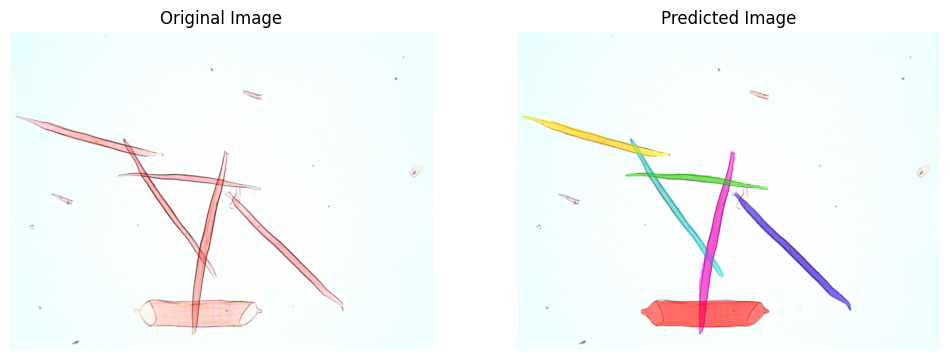

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # # Create a subplot with two columns for side-by-side display, specifying the figure size

# Display the original image on the left
axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis('off')

# Display the predicted image on the right
axes[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[1].set_title("Predicted Image")
axes[1].axis('off')

plt.show()

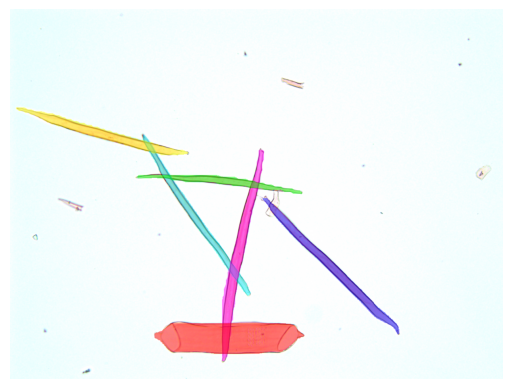

In [46]:
import matplotlib.pyplot as plt  # Import the matplotlib for displaying an image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # Display the OpenCV image using matplotlib, converting it to RGB format
plt.axis('off')  # Turn off axis labels in the displayed image
plt.show()   # Show the image using plt.show()

In [38]:
df = pd.DataFrame(list2)   # Create a DataFrame from the 'list2' data
df1 = df.rename(columns={0: 'Class Name',1: 'Length', 2: 'Width', 3: 'Area'})    # Rename the columns for clarity
excel_file_name = image_base_name + "_summary.xlsx"     # Define the name of the Excel file to be generated
df1.to_excel(excel_file_name, index=False)  # Save the DataFrame as an Excel file

# Print a message to confirm the creation of the Excel file
print(f"Excel file '{excel_file_name}' has been created.")

Excel file '131_summary.xlsx' has been created.
